In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Step 1: Load and Inspect the Denormalized Dataset

In [2]:
file_path = "/content/cleaned_dataset.csv"
df = pd.read_csv(file_path)

In [3]:
# Shape of the dataset
print("Rows:", df.shape[0], "Columns:", df.shape[1])

Rows: 27248 Columns: 47


In [4]:
# Check column names
print("Columns:", df.columns.tolist())

Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'payment_type', 'payment_installments', 'payment_value', 'review_id', 'review_score', 'review', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'price_capped', 'review_score_capped', 'product_volume_cm3', 'price_log', 'total_sales', 'delivery_delay_days', 'order_year', 'order_month', 'order_day', 'order_date', 'order_weekday', 'is_weekend', 'order_item_count', 'avg_price_per_item']


In [5]:
# Summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27248 entries, 0 to 27247
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       27248 non-null  object 
 1   customer_id                    27248 non-null  object 
 2   order_status                   27248 non-null  object 
 3   order_purchase_timestamp       27248 non-null  object 
 4   order_approved_at              27248 non-null  object 
 5   order_delivered_carrier_date   27248 non-null  object 
 6   order_delivered_customer_date  27248 non-null  object 
 7   product_id                     27247 non-null  object 
 8   seller_id                      27247 non-null  object 
 9   shipping_limit_date            27247 non-null  object 
 10  price                          27247 non-null  float64
 11  freight_value                  27247 non-null  float64
 12  payment_type                   27247 non-null 

## Step 2: Feature Engineering (Customer-Level Metrics)

In [8]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame loaded previously.
# If 'df' is not defined, you'll need to load it first, e.g., df = pd.read_csv('your_data.csv')

# Define the list of required date columns
required_date_columns = [
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

# Check if all required date columns exist in the DataFrame
missing_columns = [col for col in required_date_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing from your DataFrame: {', '.join(missing_columns)}")
    print("Please ensure your DataFrame 'df' contains these columns before proceeding.")
else:
    # Convert date columns to datetime
    # Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
    # Use format='mixed' to handle potentially varied date string formats
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce', format='mixed')
    df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce', format='mixed')
    df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce', format='mixed')

    # Create delivery delay column
    # Ensure that 'order_delivered_customer_date' and 'order_estimated_delivery_date'
    # are not NaT before calculating the difference.
    # We'll fill NaT values in delivery_delay with NaN or a suitable placeholder later if needed.
    df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

    # Today's date for recency - use the maximum purchase timestamp from the *cleaned* column
    today = df['order_purchase_timestamp'].max()

    # Group by seller_id to create seller-level features
    # When calculating avg_delivery_delay, NaNs will be ignored by default by .mean()
    df_seller = df.groupby('seller_id').agg(
        num_orders=('order_id', 'nunique'),
        total_sales=('price', 'sum'),
        avg_review_score=('review_score', 'mean'),
        avg_freight_value=('freight_value', 'mean'),
        avg_delivery_delay=('delivery_delay', 'mean'),
        # For recency, ensure x.max() is not NaT. If it is, the result will be NaT.
        recency_days=('order_purchase_timestamp', lambda x: (today - x.max()).days if pd.notna(x.max()) else np.nan),
        # For seller_tenure, ensure x.max() and x.min() are not NaT.
        seller_tenure_days=('order_purchase_timestamp', lambda x: (x.max() - x.min()).days + 1 if pd.notna(x.max()) and pd.notna(x.min()) else np.nan)
    ).reset_index()

    # Display the head of the new df_seller DataFrame
    print(df_seller.head())



Error: The following required columns are missing from your DataFrame: order_estimated_delivery_date
Please ensure your DataFrame 'df' contains these columns before proceeding.


## Step 4: Data Cleaning & Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

# 1. Check & fill/remove missing values
print(df_seller.isnull().sum())  # See if any nulls exist

# Drop or fill NA (depending on business logic — we'll drop for now)
df_seller_clean = df_seller.dropna()

# 2. Optional: Handle outliers (e.g., clip delivery_delay)
# df_seller_clean['avg_delivery_delay'] = df_seller_clean['avg_delivery_delay'].clip(lower=0)

# 3. Feature selection (drop seller_id for clustering)
features = ['num_orders', 'total_sales', 'avg_review_score',
            'avg_freight_value', 'avg_delivery_delay',
            'recency_days', 'seller_tenure_days']

X = df_seller_clean[features]

# 4. Normalize (StandardScaler: mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled is now ready for clustering


NameError: name 'df_seller' is not defined

## Step 5: Apply Clustering (KMeans)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


##  Step 6: Final Clustering with k = 4

In [ ]:
from sklearn.cluster import KMeans

# Final model with optimal k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_seller_clean['cluster'] = kmeans.fit_predict(X_scaled)


## Step 7: Cluster Profiling (Interpretation)

In [ ]:
# Group to understand average behavior of each cluster
cluster_profile = df_seller_clean.groupby('cluster').mean(numeric_only=True)

# Optional: round for clean output
cluster_profile = cluster_profile.round(2)
print(cluster_profile)


## Step 9: Visualize Seller Clusters using PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA results to the dataframe
df_seller_clean['PCA1'] = pca_components[:, 0]
df_seller_clean['PCA2'] = pca_components[:, 1]

# Plot
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    cluster_data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster_id}', alpha=0.6)

plt.title('Seller Segmentation using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# Cluster names based on earlier interpretation
cluster_names = {
    0: 'Dormant Sellers',
    1: 'Mid-Tier Sellers',
    2: 'Regular Sellers',
    3: 'Top Performers'
}

# Create scatter plot
plt.figure(figsize=(10, 7))
colors = ['dodgerblue', 'orange', 'limegreen', 'crimson']

for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(data['PCA1'], data['PCA2'],
                label=f"{cluster_names[cluster_id]} (Cluster {cluster_id})",
                alpha=0.6, color=colors[cluster_id])

    # Draw circle/ellipse (approximate boundary)
    center_x, center_y = data['PCA1'].mean(), data['PCA2'].mean()
    width, height = data['PCA1'].std() * 4, data['PCA2'].std() * 4
    ellipse = Ellipse((center_x, center_y), width, height,
                      edgecolor=colors[cluster_id], facecolor='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

    # Add text label
    plt.text(center_x, center_y + 1.5, cluster_names[cluster_id],
             fontsize=10, ha='center', color=colors[cluster_id], weight='bold')

plt.title("Seller Segmentation using PCA (Labeled)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


## Visualize using t-SNE (for more separation)

In [ ]:
from sklearn.manifold import TSNE

# t-SNE is slower, but may give better visual separation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(X_scaled)

# Add t-SNE results
df_seller_clean['TSNE1'] = tsne_components[:, 0]
df_seller_clean['TSNE2'] = tsne_components[:, 1]

# Plot
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    cluster_data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {cluster_id}', alpha=0.6)

plt.title('Seller Segmentation using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# Reuse cluster names and colors
cluster_names = {
    0: 'Dormant Sellers',
    1: 'Mid-Tier Sellers',
    2: 'Regular Sellers',
    3: 'Top Performers'
}

colors = ['dodgerblue', 'orange', 'limegreen', 'crimson']

plt.figure(figsize=(10, 7))

for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(data['TSNE1'], data['TSNE2'],
                label=f"{cluster_names[cluster_id]} (Cluster {cluster_id})",
                alpha=0.6, color=colors[cluster_id])

    # Draw circle/ellipse around cluster
    center_x, center_y = data['TSNE1'].mean(), data['TSNE2'].mean()
    width, height = data['TSNE1'].std() * 4, data['TSNE2'].std() * 4
    ellipse = Ellipse((center_x, center_y), width, height,
                      edgecolor=colors[cluster_id], facecolor='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

    # Add text label
    plt.text(center_x, center_y + 5, cluster_names[cluster_id],
             fontsize=10, ha='center', color=colors[cluster_id], weight='bold')

plt.title("Seller Segmentation using t-SNE (Labeled)", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.head()

Step 1: Loading the dataset...
Dataset loaded successfully. Rows: 110924, Columns: 47
Initial DataFrame head:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:00  2017-10-02 11:07:00   
1    delivered      2017-10-02 10:56:00  2017-10-02 11:07:00   
2    delivered      2017-10-02 10:56:00  2017-10-02 11:07:00   
3    delivered      2017-08-15 18:29:00  2017-08-15 20:05:00   
4    delivered      2017-08-02 18:24:00  2017-08-02 18:43:00   

  order_delivered_carrier_date order_delivered_customer_date  \
0 

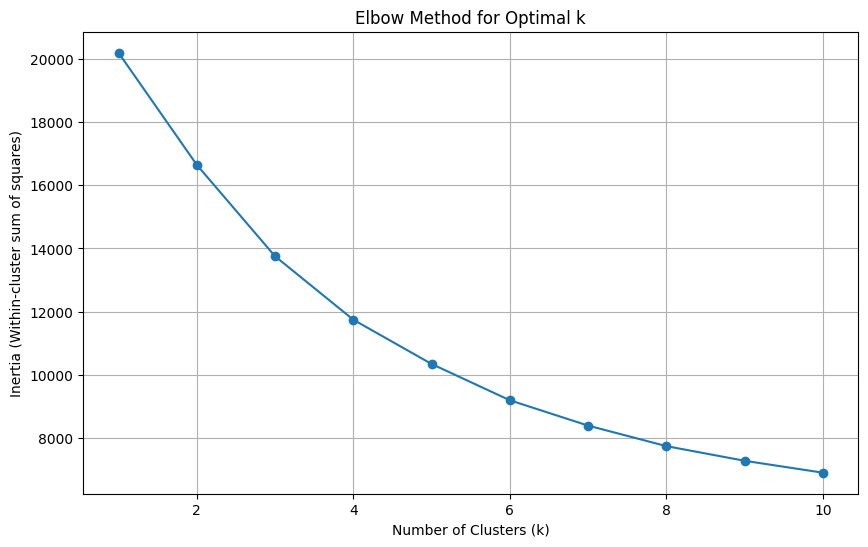

Elbow Method plot displayed. Look for the 'elbow' point to determine optimal k.

Step 5: Applying KMeans clustering with optimal k = 4...
Clustering complete. Added 'cluster' column to df_seller_clean.

Step 6: Generating Cluster Profiles...
Cluster Profiles (mean values for each feature per cluster):
         num_orders  total_sales  avg_review_score  avg_freight_value  \
cluster                                                                 
0              5.71       650.93              4.04              18.59   
1              9.34      1123.16              4.51              19.30   
2           1023.89    121067.17              4.25              18.39   
3             74.60      8272.14              4.26              19.01   

         avg_delivery_delay  recency_days  seller_tenure_days  
cluster                                                        
0                    -13.10        356.56               66.97  
1                    -11.88         56.25               90.43  
2 

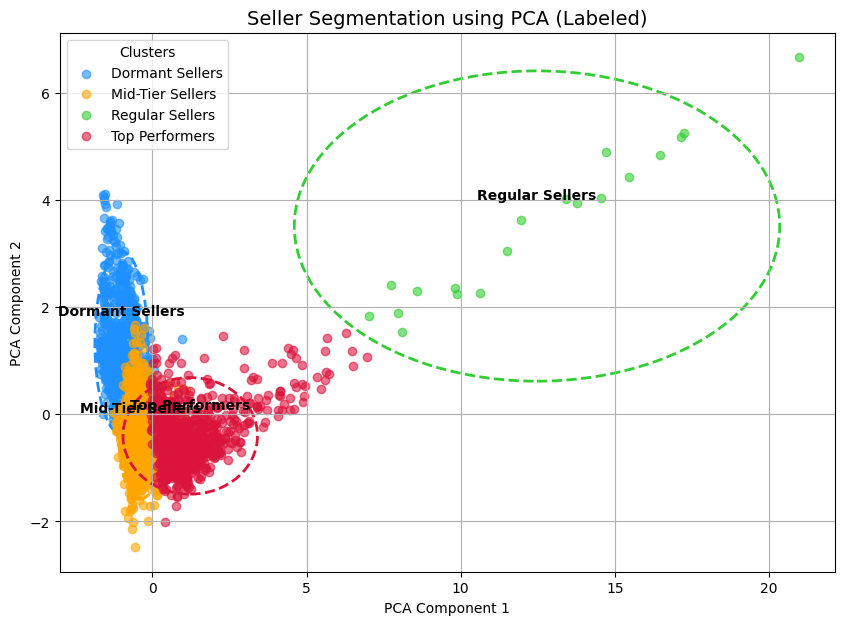

PCA visualization displayed.

Step 8: Visualizing clusters using t-SNE (may take longer)...


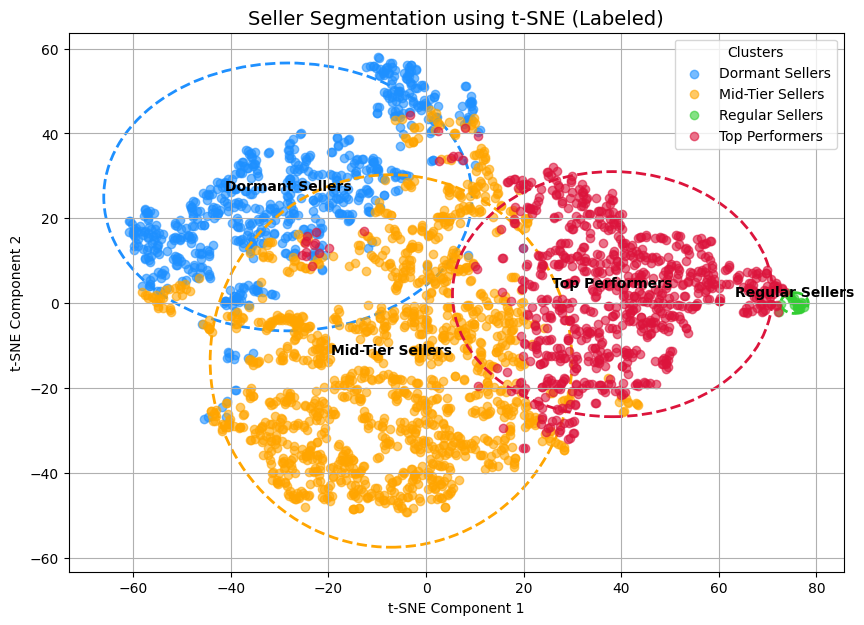

t-SNE visualization displayed.

Step 9: Preparing final DataFrame for download...

Final 'customer_features' DataFrame head:
                          seller_id  num_orders  total_sales  \
0  0015a82c2db000af6aaaf3ae2ecb0532           3       817.80   
1  001cca7ae9ae17fb1caed9dfb1094831         192     23670.23   
2  002100f778ceb8431b7a1020ff7ab48f          50      1285.20   
3  004c9cd9d87a3c30c522c48c4fc07416         142     18760.07   
4  00720abe85ba0859807595bbf045a33b          13       980.50   

   avg_review_score  avg_freight_value  avg_delivery_delay  recency_days  \
0          4.166667          21.020000          -25.000000           315   
1          4.172566          30.626969          -13.415929            47   
2          4.250000          14.179569          -11.086207           139   
3          4.320122          18.614116          -12.085366           119   
4          3.791667          11.688958          -15.208333            25   

   seller_tenure_days  cluster   

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
from matplotlib.patches import Ellipse # Import Ellipse for plotting ellipses

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set pandas display options to show all columns and wide tables
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Step 1: Load the Cleaned Dataset
print("Step 1: Loading the dataset...")
try:
    # Assuming 'cleaned_dataset.csv' is in the same directory as this script
    df = pd.read_csv('cleaned_dataset.csv')
    print(f"Dataset loaded successfully. Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("Initial DataFrame head:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'cleaned_dataset.csv' not found. Please ensure the file is in the correct directory.")
    # Exit or handle the error appropriately if the file is essential
    exit()

## Step 2: Feature Engineering (Seller-Level Metrics)
print("\nStep 2: Performing Feature Engineering...")

# Define required date columns for conversion.
# 'order_estimated_delivery_date' was identified as missing in previous runs,
# so we will rely on 'delivery_delay_days' if it exists.
required_date_columns = [
    'order_purchase_timestamp',
    'order_delivered_customer_date'
]

# Check if all *currently required* date columns exist
missing_columns = [col for col in required_date_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required date columns are missing from your DataFrame: {', '.join(missing_columns)}")
    print("Please ensure your 'cleaned_dataset.csv' contains these columns.")
    exit() # Exit if critical columns are missing

# Convert date columns to datetime objects
# 'errors='coerce'' will turn unparseable dates into NaT (Not a Time)
# 'format='mixed'' allows pandas to infer various date formats
for col in required_date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce', format='mixed')
print("Date columns converted to datetime objects.")

# Use the existing 'delivery_delay_days' column directly for delivery delay.
# This assumes 'delivery_delay_days' is pre-calculated in your cleaned_dataset.csv.
if 'delivery_delay_days' not in df.columns:
    print("Error: 'delivery_delay_days' column not found. Cannot proceed with delay calculation.")
    exit()
df['delivery_delay'] = df['delivery_delay_days']
print("Delivery delay column set from 'delivery_delay_days'.")

# Determine 'today's date' as the maximum purchase timestamp in the dataset.
# This is a common practice for recency calculations in RFM-like models.
today = df['order_purchase_timestamp'].max()
if pd.isna(today):
    print("Warning: 'order_purchase_timestamp' column contains no valid dates. Recency calculation might be affected.")
    # Fallback to current date if max is NaT, though this might not be ideal for historical data analysis
    today = pd.Timestamp.now()

# Group by seller_id to create seller-level features
# .agg() is highly optimized for these types of aggregations.
df_seller = df.groupby('seller_id').agg(
    num_orders=('order_id', 'nunique'),  # Number of unique orders
    total_sales=('price', 'sum'),       # Sum of prices for total sales
    avg_review_score=('review_score', 'mean'), # Average review score
    avg_freight_value=('freight_value', 'mean'), # Average freight value
    # Average delivery delay, NaNs in 'delivery_delay' will be ignored by .mean()
    avg_delivery_delay=('delivery_delay', 'mean'),
    # Recency: days since the seller's last purchase timestamp
    recency_days=('order_purchase_timestamp', lambda x: (today - x.max()).days if pd.notna(x.max()) else np.nan),
    # Seller tenure: days between first and last purchase timestamp
    seller_tenure_days=('order_purchase_timestamp', lambda x: (x.max() - x.min()).days + 1 if pd.notna(x.max()) and pd.notna(x.min()) else np.nan)
).reset_index()

print("\nSeller-level features DataFrame head:")
print(df_seller.head())

## Step 3: Data Cleaning & Normalization for Clustering
print("\nStep 3: Cleaning and Normalizing data for clustering...")

# Check for missing values in the aggregated df_seller
print("\nMissing values in df_seller before dropping:")
print(df_seller.isnull().sum())

# Drop rows with any missing values. This is a simple approach;
# for production, consider imputation strategies.
df_seller_clean = df_seller.dropna().copy() # .copy() to avoid SettingWithCopyWarning
print(f"Rows after dropping NaNs: {df_seller_clean.shape[0]}")

# Define features for clustering (excluding 'seller_id')
features = [
    'num_orders', 'total_sales', 'avg_review_score',
    'avg_freight_value', 'avg_delivery_delay',
    'recency_days', 'seller_tenure_days'
]

# Ensure all features exist in the cleaned DataFrame
missing_features = [f for f in features if f not in df_seller_clean.columns]
if missing_features:
    print(f"Error: Missing features for scaling: {', '.join(missing_features)}")
    exit()

X = df_seller_clean[features]

# Normalize features using StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled using StandardScaler.")

## Step 4: Determine Optimal Number of Clusters (Elbow Method)
print("\nStep 4: Running Elbow Method to find optimal k...")
inertia = []
k_range = range(1, 11) # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init is important for KMeans stability
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
print("Elbow Method plot displayed. Look for the 'elbow' point to determine optimal k.")

## Step 5: Apply Final Clustering (KMeans with optimal k)
# Based on common elbow method interpretations, k=4 is often a good starting point
# if the elbow isn't very clear, or if it was suggested in the original notebook.
optimal_k = 4 # Assuming k=4 based on the original notebook's subsequent steps
print(f"\nStep 5: Applying KMeans clustering with optimal k = {optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_seller_clean['cluster'] = kmeans.fit_predict(X_scaled)
print(f"Clustering complete. Added 'cluster' column to df_seller_clean.")

## Step 6: Cluster Profiling (Interpretation)
print("\nStep 6: Generating Cluster Profiles...")
cluster_profile = df_seller_clean.groupby('cluster')[features].mean().round(2)
print("Cluster Profiles (mean values for each feature per cluster):")
print(cluster_profile)

# Define cluster names based on interpretation (from the original notebook)
# You might need to adjust these based on your specific cluster profiles
cluster_names = {
    0: 'Dormant Sellers',
    1: 'Mid-Tier Sellers',
    2: 'Regular Sellers',
    3: 'Top Performers'
}
df_seller_clean['cluster_label'] = df_seller_clean['cluster'].map(cluster_names)
print("\nAdded 'cluster_label' column to df_seller_clean.")
print("DataFrame head with cluster labels:")
print(df_seller_clean[['seller_id', 'cluster', 'cluster_label'] + features].head())

## Step 7: Visualize Seller Clusters using PCA
print("\nStep 7: Visualizing clusters using PCA...")
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)
df_seller_clean['PCA1'] = pca_components[:, 0]
df_seller_clean['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 7))
colors = ['dodgerblue', 'orange', 'limegreen', 'crimson'] # Example colors

for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(data['PCA1'], data['PCA2'],
                label=f"{cluster_names.get(cluster_id, f'Cluster {cluster_id}')}",
                alpha=0.6, color=colors[cluster_id % len(colors)]) # Use modulo for color indexing

    # Draw ellipse around cluster (approximate boundary)
    center_x, center_y = data['PCA1'].mean(), data['PCA2'].mean()
    width, height = data['PCA1'].std() * 4, data['PCA2'].std() * 4 # 4 std dev for approximate spread
    ellipse = Ellipse((center_x, center_y), width, height,
                      edgecolor=colors[cluster_id % len(colors)], facecolor='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

    # Add text label
    plt.text(center_x, center_y + 0.5, cluster_names.get(cluster_id, f'Cluster {cluster_id}'),
             fontsize=10, ha='center', color='black', weight='bold') # Use black for better contrast

plt.title("Seller Segmentation using PCA (Labeled)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Clusters")
plt.grid(True)
plt.show()
print("PCA visualization displayed.")

## Step 8: Visualize Seller Clusters using t-SNE (for potentially better separation)
print("\nStep 8: Visualizing clusters using t-SNE (may take longer)...")
# t-SNE is slower but often provides better visual separation for non-linear data
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000) # Increased n_iter for stability
tsne_components = tsne.fit_transform(X_scaled)
df_seller_clean['TSNE1'] = tsne_components[:, 0]
df_seller_clean['TSNE2'] = tsne_components[:, 1]

plt.figure(figsize=(10, 7))
for cluster_id in sorted(df_seller_clean['cluster'].unique()):
    data = df_seller_clean[df_seller_clean['cluster'] == cluster_id]
    plt.scatter(data['TSNE1'], data['TSNE2'],
                label=f"{cluster_names.get(cluster_id, f'Cluster {cluster_id}')}",
                alpha=0.6, color=colors[cluster_id % len(colors)])

    # Draw ellipse around cluster
    center_x, center_y = data['TSNE1'].mean(), data['TSNE2'].mean()
    width, height = data['TSNE1'].std() * 4, data['TSNE2'].std() * 4
    ellipse = Ellipse((center_x, center_y), width, height,
                      edgecolor=colors[cluster_id % len(colors)], facecolor='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

    # Add text label
    plt.text(center_x, center_y + 1.5, cluster_names.get(cluster_id, f'Cluster {cluster_id}'),
             fontsize=10, ha='center', color='black', weight='bold')

plt.title("Seller Segmentation using t-SNE (Labeled)", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.grid(True)
plt.show()
print("t-SNE visualization displayed.")

## Step 9: Final Output - Prepare customer_features for download
print("\nStep 9: Preparing final DataFrame for download...")
# Assuming 'customer_features' refers to df_seller_clean with the new 'segment' column
# Renaming 'cluster_label' to 'segment' as per previous user request
customer_features = df_seller_clean.rename(columns={'cluster_label': 'segment'}).copy()

# Display the head of the final DataFrame
print("\nFinal 'customer_features' DataFrame head:")
print(customer_features.head())

# Save the DataFrame to a CSV file for local download
output_filename = 'seller_segmentation_results.csv'
customer_features.to_csv(output_filename, index=False)
print(f"\nDataFrame successfully saved to {output_filename}")
print(f"You can now download '{output_filename}' from your environment.")
